**Bagging Regressor Pipeline for Accurate Real Estate Valuation**

```
**Key Highlights:**

*   Feature Engineering: Automated transformations and target alignment to handle diverse property datasets.

*   Predictive Modeling: Optimized Bagging Regressor within an sklearn Pipeline.

*   Evaluation: R², MAE, RMSE, overfitting gap, residual analysis, and cross-validation stability assessment.

*   Production Ready: Pipeline saved with versioning and load verification for seamless deployment.
```



In [42]:
# Imports
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline

import joblib
import pickle
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from google.colab import drive

output_dir = "/content/models"
os.makedirs(output_dir, exist_ok=True)

print("✅ Environment ready!")


✅ Environment ready!


In [43]:
import pandas as pd

# Load dataset
data = pd.read_csv("Real Estate Data V21.csv")

# Dataset overview
print(f"   Dataset Overview:")
print(f"   Shape: {data.shape}")
print(f"   Columns: {list(data.columns)}")
print(f"   Missing values: {data.isnull().sum().sum()}")
print(f"   Duplicates: {data.duplicated().sum()}")

# Sample rows
print(f"\n Sample Data:")
data.head(10)


   Dataset Overview:
   Shape: (14528, 9)
   Columns: ['Name', 'Property Title', 'Price', 'Location', 'Total_Area', 'Price_per_SQFT', 'Description', 'Baths', 'Balcony']
   Missing values: 0
   Duplicates: 8

 Sample Data:


,Name,Property Title,Price,Location,Total_Area,Price_per_SQFT,Description,Baths,Balcony
0,Casagrand ECR 14,"4 BHK Flat for sale in Kanathur Reddikuppam, C...",₹1.99 Cr,"Kanathur Reddikuppam, Chennai",2583,7700.0,Best 4 BHK Apartment for modern-day lifestyle ...,4,Yes
1,"Ramanathan Nagar, Pozhichalur,Chennai",10 BHK Independent House for sale in Pozhichal...,₹2.25 Cr,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210.0,Looking for a 10 BHK Independent House for sal...,6,Yes
2,DAC Prapthi,"3 BHK Flat for sale in West Tambaram, Chennai",₹1.0 Cr,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580.0,"Property for sale in Tambaram, Chennai. This 3...",3,No
3,"Naveenilaya,Chepauk, Triplicane,Chennai",7 BHK Independent House for sale in Triplicane...,₹3.33 Cr,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840.0,Entire Building for sale with 7 units of singl...,5,Yes
4,VGN Spring Field Phase 1,"2 BHK Flat for sale in Avadi, Chennai",₹48.0 L,"Avadi, Chennai",960,5000.0,"Property for sale in Avadi, Chennai. This 2 BH...",3,Yes
5,KG Earth Homes,"2 BHK Flat for sale in Siruseri, Chennai",₹40.0 L,"Siruseri, Chennai",940,4250.0,"Price negotiable. Big hall, big balcony, gated...",3,No
6,"THIRAN FLATS ,Gowrivakkam, Sembakkam,Chennai","2 BHK Flat for sale in Sembakkam, Chennai",₹60.0 L,"THIRAN FLATS ,Gowrivakkam, Sembakkam,Chennai",880,6820.0,2 BHK Apartment for sale in Chennai. This prop...,3,Yes
7,TK Jasmine Grove,3 BHK Independent House for sale in Mahindra W...,₹72.35 L,"Mahindra World City, Chennai",1700,4250.0,A 3 BHK Independent House for sale in Mahindra...,3,Yes
8,Avenue,"2 BHK Flat for sale in West Tambaram, Chennai",₹42.0 L,"Brindavan Colony, West Tambaram,Chennai",840,5000.0,Check out this 2 BHK Apartment for sale in Tam...,3,No
9,Guru Kothai Aparts,"1 BHK Flat for sale in Chromepet, Chennai",₹30.0 L,"New Colony, Chromepet,Chennai",535,5610.0,We are the proud owners of this 1 bhk apartmen...,2,No


In [44]:
import importlib
import sys

if 'feature_engineering' in sys.modules:
    importlib.reload(sys.modules['feature_engineering'])

from feature_engineering import RealEstateFeatureEngineer

print("✅ RealEstateFeatureEngineer loaded successfully!")


 RealEstateFeatureEngineer class loaded from feature_engineering module!
✅ RealEstateFeatureEngineer loaded successfully!


In [45]:
# ✅ Initialize Real Estate Price Prediction Pipeline

feature_engineer = RealEstateFeatureEngineer()

bagging_model = BaggingRegressor(
    n_estimators=15,
    max_samples=0.6,
    max_features=0.6,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline([
    ('feature_engineer', feature_engineer),
    ('model', bagging_model)
])

print("Pipeline initialized successfully!")
print(f" Feature Engineer: {type(pipeline.named_steps['feature_engineer']).__name__}")
print(f" Model: {type(pipeline.named_steps['model']).__name__}")


Pipeline initialized successfully!
 Feature Engineer: RealEstateFeatureEngineer
 Model: BaggingRegressor


In [46]:
print("🚀 Training Real Estate Price Prediction Pipeline\n")

# --- Feature Engineering ---
temp_feature_engineer = RealEstateFeatureEngineer()
temp_feature_engineer.fit(data)

y_all = temp_feature_engineer.get_target(data)
data_aligned = data.loc[y_all.index]

print(f"✅ Data Ready → {data.shape[1]} features | {len(data_aligned)} samples (after cleaning)\n")

# --- Train-Test Split ---
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    data_aligned, y_all,
    test_size=0.2,
    random_state=42,
    stratify=data_aligned['City'] if 'City' in data_aligned.columns else None
)
print(f"✅ Split → Train: {len(X_train_raw)} | Test: {len(X_test_raw)}\n")

# --- Train Pipeline ---
pipeline.fit(X_train_raw, y_train)
print("✅ Pipeline training completed!\n")

# --- Predictions ---
y_train_pred = pipeline.predict(X_train_raw)
y_test_pred = pipeline.predict(X_test_raw)
print("✅ Predictions generated!\n")

# --- Metrics ---
results = {
    "Train R²": r2_score(y_train, y_train_pred),
    "Test R²": r2_score(y_test, y_test_pred),
    "Train MAE": mean_absolute_error(y_train, y_train_pred),
    "Test MAE": mean_absolute_error(y_test, y_test_pred),
    "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
    "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
}

print("📊 Model Performance")
for k, v in results.items():
    print(f"{k:<10} → {v:.4f}" if "R²" in k else f"{k:<10} → {v:.2f}")

gap = ((results["Train R²"] - results["Test R²"]) / results["Train R²"] * 100)
print(f"\n⚖️ Overfitting Gap → {gap:.1f}%\n")

# --- Save globals for later use ---
X_train_global, X_test_global = X_train_raw, X_test_raw
y_train_global, y_test_global = y_train, y_test
print("✅ Globals saved for later use!\n")


🚀 Training Real Estate Price Prediction Pipeline

 Fitting Feature Engineering Pipeline (Multiple Algorithms Method)...
   Applying outlier removal...
     Removed 2641 outliers (18.2%)
 Feature Engineering Pipeline fitted with Multiple Algorithms method!
✅ Data Ready → 9 features | 11879 samples (after cleaning)

✅ Split → Train: 9503 | Test: 2376

 Fitting Feature Engineering Pipeline (Multiple Algorithms Method)...
   Applying outlier removal...
     Removed 985 outliers (10.4%)
 Feature Engineering Pipeline fitted with Multiple Algorithms method!
 Transforming data...
 Transformed data shape: (9503, 18)
✅ Pipeline training completed!

 Transforming data...
 Transformed data shape: (9503, 18)
 Transforming data...
 Transformed data shape: (2376, 18)
✅ Predictions generated!

📊 Model Performance
Train R²   → 0.9180
Test R²    → 0.8496
Train MAE  → 8.34
Test MAE   → 11.38
Train RMSE → 12.03
Test RMSE  → 16.26

⚖️ Overfitting Gap → 7.5%

✅ Globals saved for later use!



🧾 Comprehensive Model Evaluation

✅ Using train/test split → Train: 9503, Test: 2376

 Transforming data...
 Transformed data shape: (9503, 18)
 Transforming data...
 Transformed data shape: (2376, 18)
📊 Performance Metrics
 Train R²       → 0.9180 (91.8%)
 Test R²        → 0.8496 (85.0%)
 Overfitting    → 7.46% gap
 Test MAE       → ₹11.38L
 Test RMSE      → ₹16.26L

🔄 Cross-Validation (5-Fold)
 CV R² Scores   → ['0.8661', '0.8446', '0.8503', '0.8520', '0.8498']
 Mean CV R²     → 0.8526
 Std Dev        → 0.0072
 Stability      → Excellent

⚠️ Error Analysis (Test Set)
 Median Abs Error   → ₹7.66L
 Median Error %     → 15.3%
 90th % Error       → 43.2%
 Within 15% Error   → 49.1%
 Within 25% Error   → 72.3%



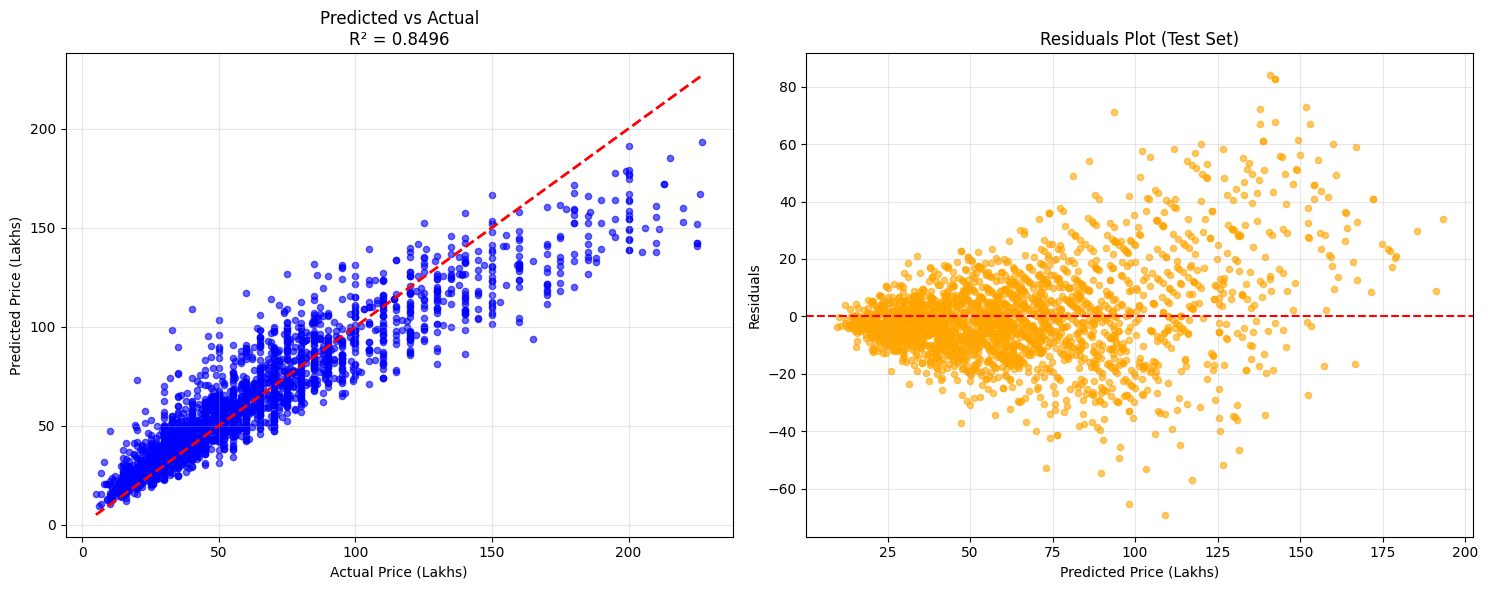

✅ Model Validation Completed!
 Final Test R² → 85.0%



In [47]:
print("🧾 Comprehensive Model Evaluation\n")

# --- Data Setup ---
X_train, X_test = X_train_global, X_test_global
y_train, y_test = y_train_global, y_test_global
data_aligned = pd.concat([X_train, X_test])
y_all = pd.concat([y_train, y_test])

print(f"✅ Using train/test split → Train: {len(X_train)}, Test: {len(X_test)}\n")

# --- Predictions ---
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# --- Metrics ---
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

overfitting_gap = train_r2 - test_r2
overfitting_pct = (overfitting_gap / train_r2) * 100

print("📊 Performance Metrics")
print(f" Train R²       → {train_r2:.4f} ({train_r2*100:.1f}%)")
print(f" Test R²        → {test_r2:.4f} ({test_r2*100:.1f}%)")
print(f" Overfitting    → {overfitting_pct:.2f}% gap")
print(f" Test MAE       → ₹{test_mae:.2f}L")
print(f" Test RMSE      → ₹{test_rmse:.2f}L\n")

# --- Cross Validation ---
print("🔄 Cross-Validation (5-Fold)")
import feature_engineering # Import the module again for cross-validation
cv_scores = cross_val_score(pipeline, data_aligned, y_all, cv=5, scoring='r2', n_jobs=-1)
print(f" CV R² Scores   → {[f'{score:.4f}' for score in cv_scores]}")
print(f" Mean CV R²     → {cv_scores.mean():.4f}")
print(f" Std Dev        → {cv_scores.std():.4f}")

stability = "Excellent" if cv_scores.std() < 0.02 else "Good" if cv_scores.std() < 0.05 else "Moderate"
print(f" Stability      → {stability}\n")

# --- Error Analysis ---
residuals = y_test - y_test_pred
error_pct = np.abs(residuals) / y_test * 100

print("⚠️ Error Analysis (Test Set)")
print(f" Median Abs Error   → ₹{np.median(np.abs(residuals)):.2f}L")
print(f" Median Error %     → {error_pct.median():.1f}%")
print(f" 90th % Error       → {np.percentile(error_pct, 90):.1f}%")
print(f" Within 15% Error   → {(error_pct <= 15).mean()*100:.1f}%")
print(f" Within 25% Error   → {(error_pct <= 25).mean()*100:.1f}%\n")

# --- Visualizations ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Predicted vs Actual
axes[0].scatter(y_test, y_test_pred, alpha=0.6, color='blue', s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price (Lakhs)')
axes[0].set_ylabel('Predicted Price (Lakhs)')
axes[0].set_title(f'Predicted vs Actual\nR² = {test_r2:.4f}')
axes[0].grid(True, alpha=0.3)

# Residuals plot
axes[1].scatter(y_test_pred, residuals, alpha=0.6, color='orange', s=20)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Price (Lakhs)')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals Plot (Test Set)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Model Validation Completed!")
print(f" Final Test R² → {test_r2:.1%}\n")

In [48]:
print("🔄 Saving trained model to production...")

# Create models directory if not present
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)

# Generate timestamped version
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_version = f"v{timestamp}"
pipeline_path = os.path.join(models_dir, f"real_estate_pipeline_{model_version}.joblib")

# Save pipeline
joblib.dump(pipeline, pipeline_path)

# File size info
pipeline_size = os.path.getsize(pipeline_path) / (1024*1024)

print(f"✅ Model saved: {pipeline_path}")
print(f"   Version: {model_version}")
print(f"   Size: {pipeline_size:.2f} MB")
print(f"   Test R²: {test_r2:.1%}")

# Quick verification
try:
    loaded_pipeline = joblib.load(pipeline_path)
    print("   Load check: Success")
except Exception as e:
    print(f"   Load check failed: {e}")


🔄 Saving trained model to production...
✅ Model saved: models/real_estate_pipeline_v20250924_122040.joblib
   Version: v20250924_122040
   Size: 3.73 MB
   Test R²: 85.0%
   Load check: Success
